This notebook is a tutorial for computing SEACell metacells, visualizing results and computing evaluation metrics

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of single-nuclear RNA-seq dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [7]:
!mkdir data/
!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad 

--2022-08-17 14:35:59--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 52.217.168.129
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|52.217.168.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152569842 (146M) [binary/octet-stream]
Saving to: 'data/cd34_multiome_rna.h5ad'

data/cd34_multiome_ 100%[===================>] 145.50M  37.8MB/s    in 4.0s    

2022-08-17 14:36:03 (36.5 MB/s) - 'data/cd34_multiome_rna.h5ad' saved [152569842/152569842]



In [8]:
# Load the data using 
ad = sc.read('data/cd34_multiome_rna.h5ad')

In [9]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

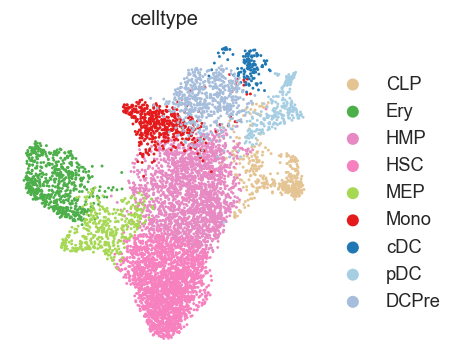

In [10]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [11]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [12]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [13]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [14]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

In [15]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [16]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [17]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6881 [00:00<?, ?it/s]

Constructing CSR matrix...


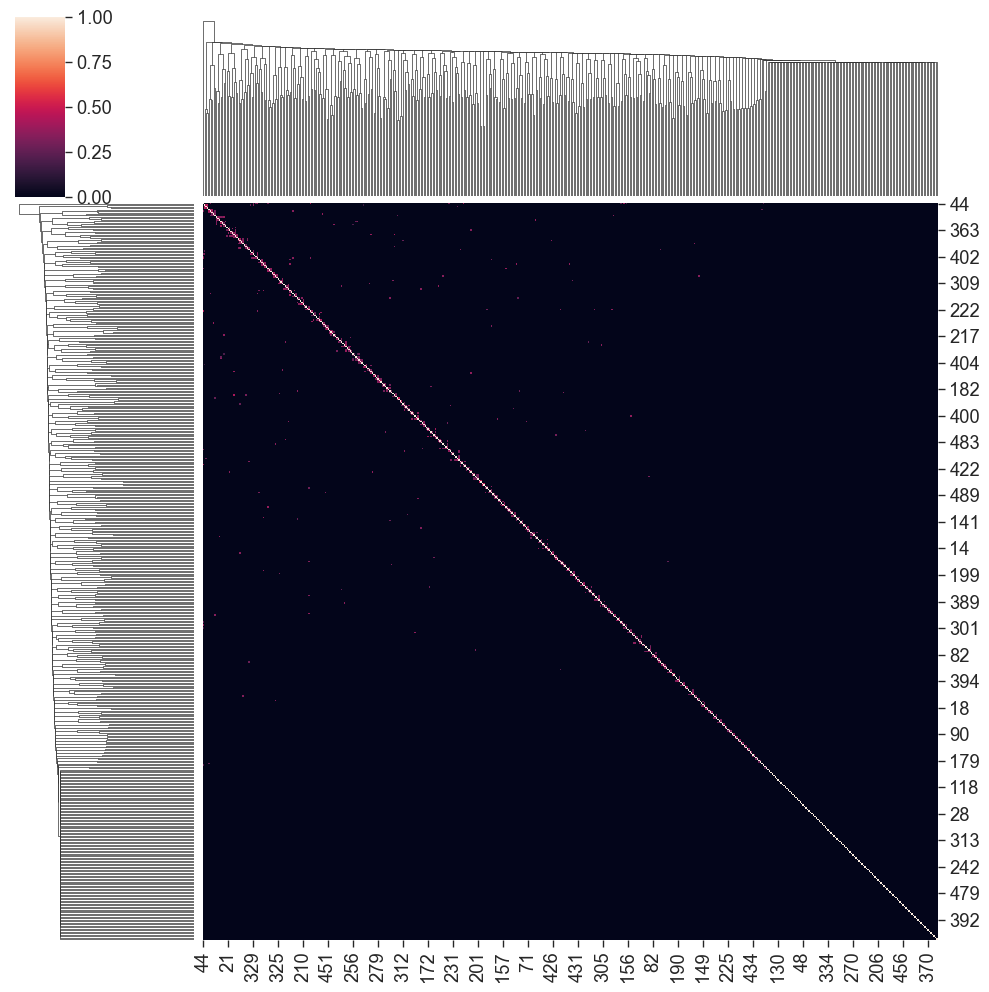

In [18]:
sns.clustermap(M.toarray()[:500,:500])

In [19]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 81 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/19 [00:00<?, ?it/s]

Selecting 9 cells from greedy initialization.


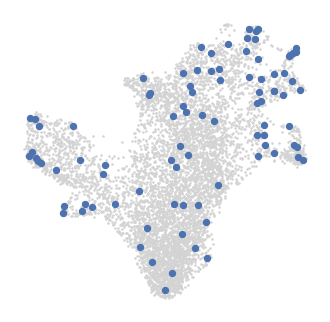

In [20]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [21]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00151
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 28 iterations.


In [22]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 29 iterations
Ran for 34 iterations


# Accessing results

## Model Convergence

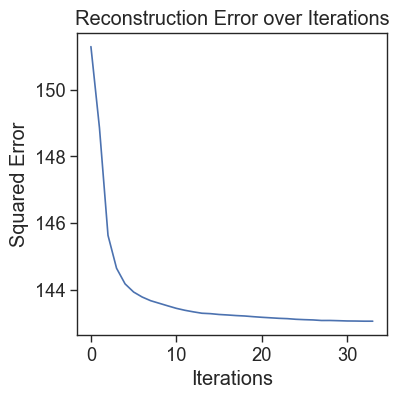

In [23]:
# Check for convergence 
model.plot_convergence()

## SEACell Hard Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEAell']` 
- from the model using `.get_hard_assignments()` 


In [24]:
ad.obs[['SEACell']].head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GTCGGTTCAAGTGTTT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#ACAACACTCATGCGTG-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep2#CAGGTCCAGACACCGC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep2#GCCTCGACAGTAGCCT-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AAACATGCAGCATGTC-1


In [25]:
model.get_hard_assignments().head()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GTCGGTTCAAGTGTTT-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#ACAACACTCATGCGTG-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep2#CAGGTCCAGACACCGC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep2#GCCTCGACAGTAGCCT-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AAACATGCAGCATGTC-1


## SEACell Soft Assignments

Archetypal analysis returns soft assignments of cells to SEACells. The full assignment matrix can be accessed as the parameter ```model.A_```. However, the majority of single-cells are assigned to no more than 4 archetypes with non-trivial weight, so we return the top 5 metacell assignments as well as the corresponding assignment weights in the function ```model.get_soft_assignments()```

/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


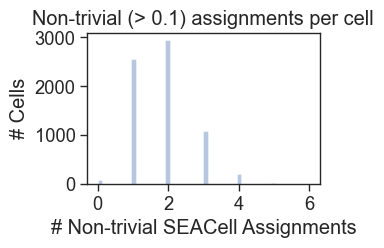

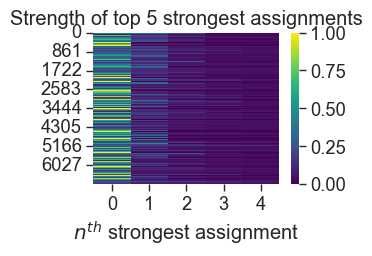

In [26]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()


In [27]:
labels,weights = model.get_soft_assignments()

In [28]:
labels.head()

,0,1,2,3,4
index,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep1#GTCGGTTCAAGTGTTT-1,cd34_multiome_rep1#AACCCGCAGTAGCTTA-1,cd34_multiome_rep2#TTGTCCGGTGAGGTGA-1,cd34_multiome_rep1#GTTGTGAGTAGTAAGA-1,cd34_multiome_rep2#AACTACTCAAGCGAGC-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#ACAACACTCATGCGTG-1,cd34_multiome_rep2#TACTTCGTCAAACCTA-1,cd34_multiome_rep1#CATTCATTCAATCTCT-1,cd34_multiome_rep1#TGCAATATCGCTAAGT-1,cd34_multiome_rep2#GTTACGCCAAGGTGGC-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep2#CAGGTCCAGACACCGC-1,cd34_multiome_rep1#ATTAGTCCACCTGCCT-1,cd34_multiome_rep1#TAGCTAGGTAGGTTAT-1,cd34_multiome_rep2#ACCGGCTAGCTTAGTA-1,cd34_multiome_rep2#CAGGACCTCCCTCAAC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep2#GCCTCGACAGTAGCCT-1,cd34_multiome_rep1#CAAGTGAAGCTTCTCA-1,cd34_multiome_rep1#GGACATAAGTTAGAGG-1,cd34_multiome_rep2#GGACGGATCCTAGTCC-1,cd34_multiome_rep2#GTACGTAGTTGTAAAC-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep2#CAGGACCTCCCTCAAC-1,cd34_multiome_rep1#CGATTTGCAGGCAAGC-1,cd34_multiome_rep2#TGTATCGCAATAATCC-1,cd34_multiome_rep2#ACAACACTCATGCGTG-1


# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in `X`. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, `ad.raw` is used for summarization. Other layers present in the anndata can be specified using the parameter `summarize_layer` parameter

In [29]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

  0%|          | 0/90 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 90 × 12464
    layers: 'raw'

Alternatively, we can take into account soft assignments of cells to SEACells by weighting cells by the strength of the assignment. A minimum assignment weight is used to zero out trivial assignments

In [30]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='celltype',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

  0%|          | 0/90 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [31]:
SEACell_soft_ad.obs.head()

,Pseudo-sizes,celltype,celltype_purity
0,26.361841,pDC,1.000000
1,20.211870,pDC,0.871574
2,266.864220,HSC,0.921319
3,47.505118,DCPre,0.910756
4,28.668484,CLP,0.981844


## Normalization

Normalization of metacell data can be performed using the `sc.pp.normalize_total` and `sc.pp.log1p` functions

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

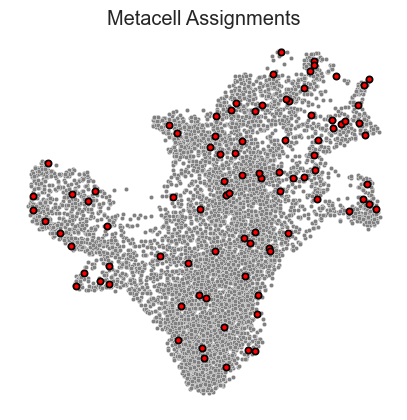

In [32]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

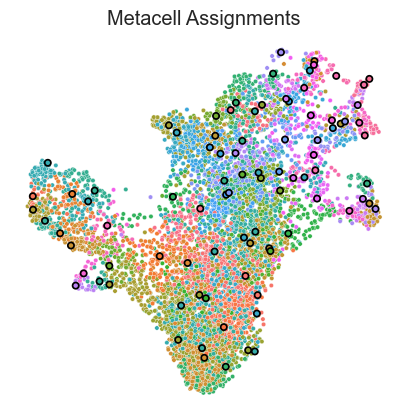

In [33]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/Users/sitarapersad/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


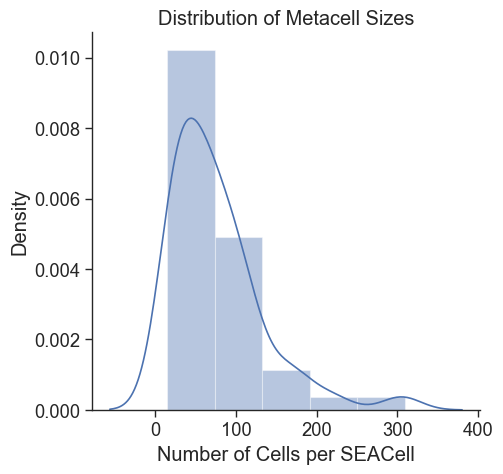

,size
SEACell,
cd34_multiome_rep1#AAACATGCAGCATGTC-1,45
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,27
cd34_multiome_rep1#AACCCGCAGTAGCTTA-1,80
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,32
cd34_multiome_rep1#AGTAAACAGGAAACTG-1,71
...,...
cd34_multiome_rep2#TAGGTTATCCGCAACA-1,91
cd34_multiome_rep2#TCCAGCAAGGATTGCT-1,73
cd34_multiome_rep2#TGTAACTCACAATGCC-1,34


In [34]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


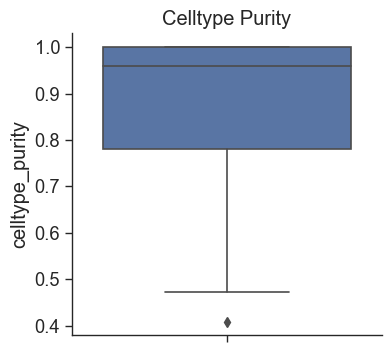

,celltype,celltype_purity
SEACell,,
cd34_multiome_rep1#AAACATGCAGCATGTC-1,Ery,1.000000
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,DCPre,1.000000
cd34_multiome_rep1#AACCCGCAGTAGCTTA-1,HMP,0.950000
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,CLP,1.000000
cd34_multiome_rep1#AGTAAACAGGAAACTG-1,MEP,0.732394


In [35]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


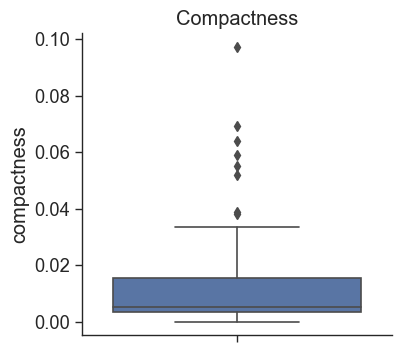

,compactness
SEACell,
cd34_multiome_rep1#AAACATGCAGCATGTC-1,0.026151
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,0.001268
cd34_multiome_rep1#AACCCGCAGTAGCTTA-1,0.004239
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,0.018388
cd34_multiome_rep1#AGTAAACAGGAAACTG-1,0.013944


In [36]:
compactness = SEACells.evaluate.compactness(ad, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


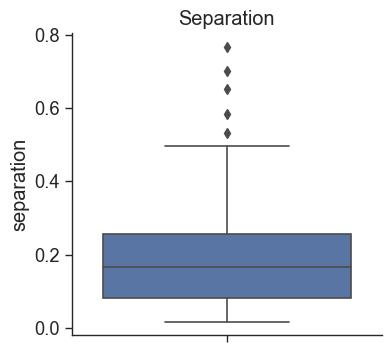

,separation
SEACell,
cd34_multiome_rep1#AAACATGCAGCATGTC-1,0.229926
cd34_multiome_rep1#AACCCGCAGCGCAATT-1,0.175089
cd34_multiome_rep1#AACCCGCAGTAGCTTA-1,0.114385
cd34_multiome_rep1#AATCCGTAGCGGTTAT-1,0.028999
cd34_multiome_rep1#AGTAAACAGGAAACTG-1,0.241499


In [37]:
separation = SEACells.evaluate.separation(ad, 'X_pca',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

In [56]:
import umap as py
py.__version__

'0.5.3'